# Train language model

In [1]:
from fastai.text import *

In [2]:
path = Path('/mnt/data1/toxic-comments/')
# path = Path('/home/tony/Documents/jigsaw-unintended-bias-in-toxicity-classification')

# Initializing language model data

### Load csv

In [ ]:
train_df = pd.read_csv(path/'train.csv')

In [ ]:
# valid_df = pd.read_csv(path/'test.csv')

### Look at the data

In [ ]:
train_df

In [ ]:
train_df.target = train_df.target.apply(lambda x : 0 if x < 0.5 else 1)

In [ ]:
train_df.to_csv(path/'train_class.csv')

### Using data bunch

In [ ]:
# data_lm = TextDataBunch.from_df(path, train_df, valid_df, text_cols='comment_text')
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', text_cols='comment_text')

In [ ]:
data_lm.save(path/'language_model.pkl')

# Prepare to train language model

## Setup model

In [ ]:
bs=46

In [ ]:
data_lm = load_data(path, 'language_model.pkl', bs=bs)

### AWD_LSTM

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.15).to_fp16()

### Transformer

In [ ]:
learn = language_model_learner(data_lm, Transformer, drop_mult=0.3).to_fp16()

### TransformerXL

In [ ]:
learn = language_model_learner(data_lm, TransformerXL, drop_mult=0.20).to_fp16()

# Load and save language model

In [ ]:
learn = learn.load('transformerXL')

In [ ]:
learn.save('transformerXL')

In [ ]:
learn.save_encoder('transformerXL_enc')

# Finding learning rate

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


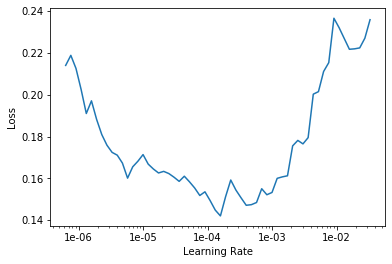

In [11]:
learn.recorder.plot(skip_end=15)

# Train language model

In [ ]:
learn.unfreeze()

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

# Prepare classification dataset

In [ ]:
data_class = (TextList.from_csv(path, 'train_class.csv', vocab=vocab, cols='comment_text')
           .split_by_rand_pct(0.1)
           .label_from_df(cols='target', label_cls=CategoryList)
           .databunch())

In [ ]:
data_class.save(path/'data_class.pkl')

# Load classification dataset

In [3]:
bs=20

In [4]:
data_class = load_data(path, 'data_class.pkl', bs=bs, num_workers=2)

# Prepare classification model

### TransformerXL

In [5]:
learn = text_classifier_learner(data_class, TransformerXL, drop_mult=0.35).to_fp16()

/home/tony/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/text/learner.py:297: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


# Load and save model

In [ ]:
learn.load_encoder('transformerXL_enc')

In [6]:
learn = learn.load('transformerXL_class')

In [13]:
learn.save('transformerXL_class')

# Find learning rate

In [8]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


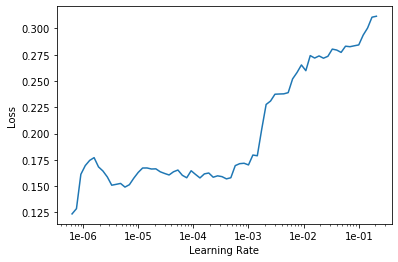

In [9]:
learn.recorder.plot()

# Train regression model

In [7]:
learn.unfreeze()

In [ ]:
learn.freeze_to(-1)

In [ ]:
learn.freeze()

In [12]:
learn.fit_one_cycle(8, 1e-5, moms=(0.8,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.154064,0.163548,0.936505,3:38:20
1,0.176964,0.165116,0.936572,3:48:17
2,0.171507,0.177509,0.936051,3:15:06
3,0.174916,0.172389,0.936533,3:11:54
4,0.180387,0.164311,0.937419,3:43:55
5,0.159415,0.169026,0.936948,3:26:29


KeyboardInterrupt: 

# Export

In [12]:
learn.export('text_toxicity.pkl')